In [12]:
import pandas as pd
import numpy as np
import json
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

np.set_printoptions(suppress=True, linewidth=np.inf)

In [13]:
'''
Attribute Information:
1.  CRIM      per capita crime rate by town
2.  ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3.  INDUS     proportion of non-retail business acres per town
4.  CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5.  NOX       nitric oxides concentration (parts per 10 million)
6.  RM        average number of rooms per dwelling
7.  AGE       proportion of owner-occupied units built prior to 1940
8.  DIS       weighted distances to five Boston employment centres
9.  RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
'''

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'TGT']
boston = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols, index_col=False)

n_validate_set = 100
n_elements = len(boston) # 506
n_train_set = n_elements - n_validate_set
n_class_reduce = 3

train = boston.iloc[:n_train_set, 0:13]
train_labels = (boston.iloc[:n_train_set, 13] * 10).astype(int)
validate = boston.iloc[n_train_set:, 0:13]
validate_labels = (boston.iloc[n_train_set:, 13] * 10).astype(int)

min_class, max_class = train_labels.min(), train_labels.max()
train_labels = (train_labels / ((max_class - min_class) / (n_class_reduce - 1))).astype(int)
validate_labels = (validate_labels / ((max_class - min_class) / (n_class_reduce - 1))).astype(int)
min_class, max_class = train_labels.min(), train_labels.max()

In [14]:
model = RandomForestClassifier(n_estimators=1000, bootstrap = True, max_features = 'sqrt')
model.fit(train, train_labels)

rf_predictions = model.predict(validate)
rf_probs = model.predict_proba(validate)[:, 1]

feature_importance = pd.DataFrame({'feature': list(train.columns), 'importance': model.feature_importances_}).sort_values('importance', ascending = False)
feature_importance["cum_sum_importance"] = feature_importance["importance"].cumsum()

Model Accuracy: 90.0%
all classes: [1 0 2], min class: 0, max class: 2
Shift statistics: Mean: 0.0, Median: 0.0, Variance: 0.1


,feature,importance,cum_sum_importance
12,LSTAT,0.237113,0.237113
5,RM,0.220185,0.457297
4,NOX,0.078807,0.536105
6,AGE,0.075252,0.611357
10,PTRATIO,0.071529,0.682885
7,DIS,0.067121,0.750006
2,INDUS,0.063450,0.813456
0,CRIM,0.060946,0.874402
11,B,0.040954,0.915356
9,TAX,0.040924,0.956280


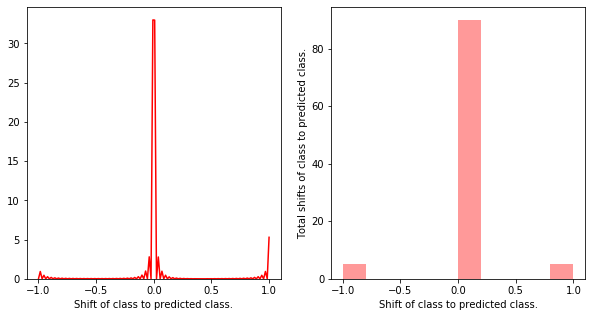

In [15]:
shifts = []
predictions_class = [[] for i in range(n_class_reduce)]
predictions_probs = [[] for i in range(n_class_reduce)]
for i in range(n_validate_set):
    correct = validate_labels.iloc[i] == rf_predictions[i]
    shift = rf_predictions[i] - validate_labels.iloc[i]
    shifts.append(shift)
    predictions_class[rf_predictions[i] - min_class].append(correct)
    if correct:
        predictions_probs[rf_predictions[i] - min_class].append(rf_probs[i])
    
    #print("class: {}, predicted class: {}, probability: {}, correct: {}, shift: {}".format(validate_labels.iloc[i], rf_predictions[i], rf_probs[i], correct, shift))
shifts = np.asarray(shifts)
print("Model Accuracy: {}%".format(model.score(validate, validate_labels) * 100))
print("all classes: {}, min class: {}, max class: {}".format(train_labels.unique(), min_class, max_class))
print("Shift statistics: Mean: {}, Median: {}, Variance: {}".format(np.mean(shifts), np.median(shifts), np.var(shifts)))
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(shifts, kde=False, hist=True, color="r", ax=axes[1])
sns.distplot(shifts, kde=True, hist=False, color="r", ax=axes[0])
axes[0].set_xlabel("Shift of class to predicted class.")
axes[1].set_xlabel("Shift of class to predicted class.")
axes[1].set_ylabel("Total shifts of class to predicted class.")
feature_importance

In [16]:
print("Model Accuracy: {}%".format(model.score(validate, validate_labels) * 100))
for i in range(n_class_reduce):
    if len(predictions_class[i]) > 0:
        print("Class {} Accuracy: {}%".format(i, np.round((np.sum(predictions_class[i]) * 100) / len(predictions_class[i]), decimals=1)))
    else: 
        print("Class {} Accuracy: {}%".format(i, 0.0))

Model Accuracy: 90.0%
Class 0 Accuracy: 94.4%
Class 1 Accuracy: 50.0%
Class 2 Accuracy: 0.0%
